In [1]:
%cd 'Deep-Learning/Assignment 2'
!ls
import sys
sys.path.append('.')  # C

/content/Deep-Learning/Assignment 2
'clusters_subchunks - ankita.ipynb'   preprocessing_clusters.ipynb
 clusters_subchunks.ipynb	      utils


In [2]:
import os
import glob
import re
import h5py
import numpy as np
import pandas as pd
import random
from typing import Tuple, Literal, Optional, List
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from scipy.signal import decimate
import matplotlib.pyplot as plt
import itertools
# For CNN/RNN
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, InputLayer
)
from tensorflow.keras.optimizers import Adam

from utils.preprocessing_utils import *
from utils.visual_utils import *
import gc
gc.collect()


0

In [3]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Training

## Intra Files

In [4]:
## TRAINING DATA ##

# intra 1
participant_id_intra = 105923
rest_intra, motor_intra, story_math_intra, wm_intra = load_participant_arrays(participant_id_intra, base_dir=r"/content/drive/MyDrive/DL part 2/Final Project data/Intra/train")


print("Rest:", None if rest_intra is None else rest_intra.shape)
print("Motor:", None if motor_intra is None else motor_intra.shape)
print("Story/Math:", None if story_math_intra is None else story_math_intra.shape)
print("Working Memory:", None if wm_intra is None else wm_intra.shape)


Rest: (248, 284992)
Motor: (248, 284992)
Story/Math: (248, 284992)
Working Memory: (248, 284992)


## Contra Files

In [5]:
## TRAINING DATA ##

# contra 1
participant_id_c1 = 113922

#contra 2
participant_id_c2 = 164636


rest_c1, motor_c1, story_math_c1, wm_c1 = load_participant_arrays(participant_id_c1, base_dir=r"/content/drive/MyDrive/DL part 2/Final Project data/Cross/train")
rest_c2, motor_c2, story_math_c2, wm_c2 = load_participant_arrays(participant_id_c2, base_dir=r"/content/drive/MyDrive/DL part 2/Final Project data/Cross/train")


print("Rest:", None if rest_c2 is None else rest_c2.shape)
print("Motor:", None if motor_c2 is None else motor_c2.shape)
print("Story/Math:", None if story_math_c2 is None else story_math_c2.shape)
print("Working Memory:", None if wm_c2 is None else wm_c2.shape)

Rest: (248, 284992)
Motor: (248, 284992)
Story/Math: (248, 284992)
Working Memory: (248, 284992)


## Training Intra

In [6]:
datasets = [rest_intra, motor_intra, story_math_intra, wm_intra]
task_names = ["rest", "motor", "story_math", "wm"]

# preprocessing all datasets
preprocessed_datasets = [
    preprocess_meg_data(
        data,
        scaling="zscore",
        downsample_method="decimate",
        target_rate=64,
        orig_rate=2034
    )
    for data in datasets
]

# clustering using averaged cosine similarity
sensor_order, cluster_labels, avg_sim_matrix = cossim_cluster_multi_task(
    preprocessed_datasets,
    n_clusters=5
)

# reorder and store data per task
reordered_data_dict = {}
sensor_order_dict = {}
cluster_labels_dict = {}

for preproc_data, name in zip(preprocessed_datasets, task_names):
    reordered_data = preproc_data[sensor_order, :]
    reordered_data_dict[f"reordered_data_{name}"] = reordered_data
    sensor_order_dict[f"sensor_order_{name}"] = sensor_order
    cluster_labels_dict[f"cluster_labels_{name}"] = cluster_labels


In [7]:
# maybe not the most efficient way oops
rest_data = reordered_data_dict["reordered_data_rest"]
rest_sensor_order = sensor_order_dict["sensor_order_rest"]
rest_clusters = cluster_labels_dict["cluster_labels_rest"]

motor_data = reordered_data_dict["reordered_data_motor"]
motor_sensor_order = sensor_order_dict["sensor_order_motor"]
motor_clusters = cluster_labels_dict["cluster_labels_motor"]

story_math_data = reordered_data_dict["reordered_data_story_math"]
story_math_sensor_order = sensor_order_dict["sensor_order_story_math"]
story_math_clusters = cluster_labels_dict["cluster_labels_story_math"]

wm_data = reordered_data_dict["reordered_data_wm"]
wm_sensor_order = sensor_order_dict["sensor_order_wm"]
wm_clusters = cluster_labels_dict["cluster_labels_wm"]


### Data Visualization

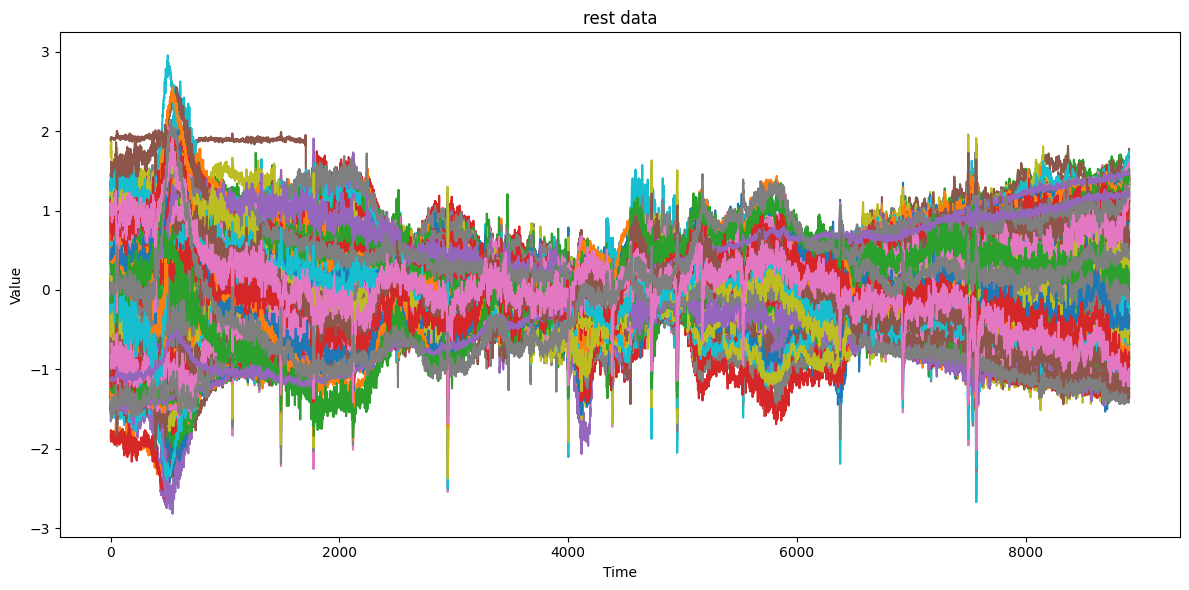

In [8]:
plt.figure(figsize=(12, 6))
for i in range(248):  # You can increase this to show more rows
    plt.plot(rest_data[i], label=f"Row {i}")

plt.xlabel("Time")
plt.ylabel("Value")
plt.title("rest data")
plt.tight_layout()
plt.show()

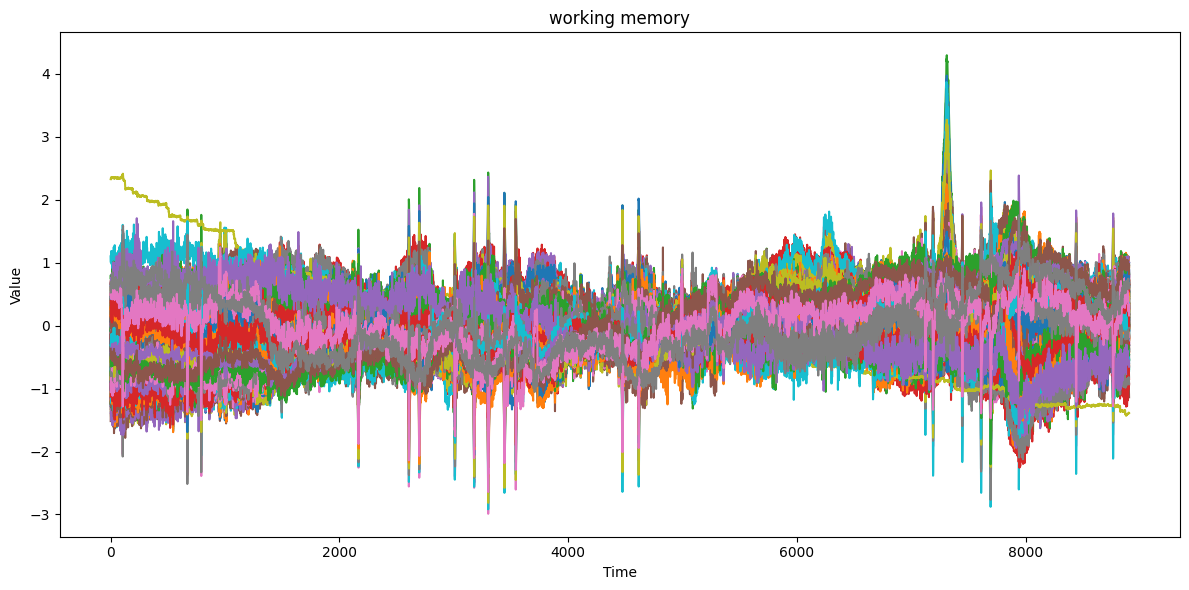

In [9]:
plt.figure(figsize=(12, 6))
for i in range(248):  # You can increase this to show more rows
    plt.plot(wm_data[i], label=f"Row {i}")

plt.xlabel("Time")
plt.ylabel("Value")
plt.title("working memory")
plt.tight_layout()
plt.show()

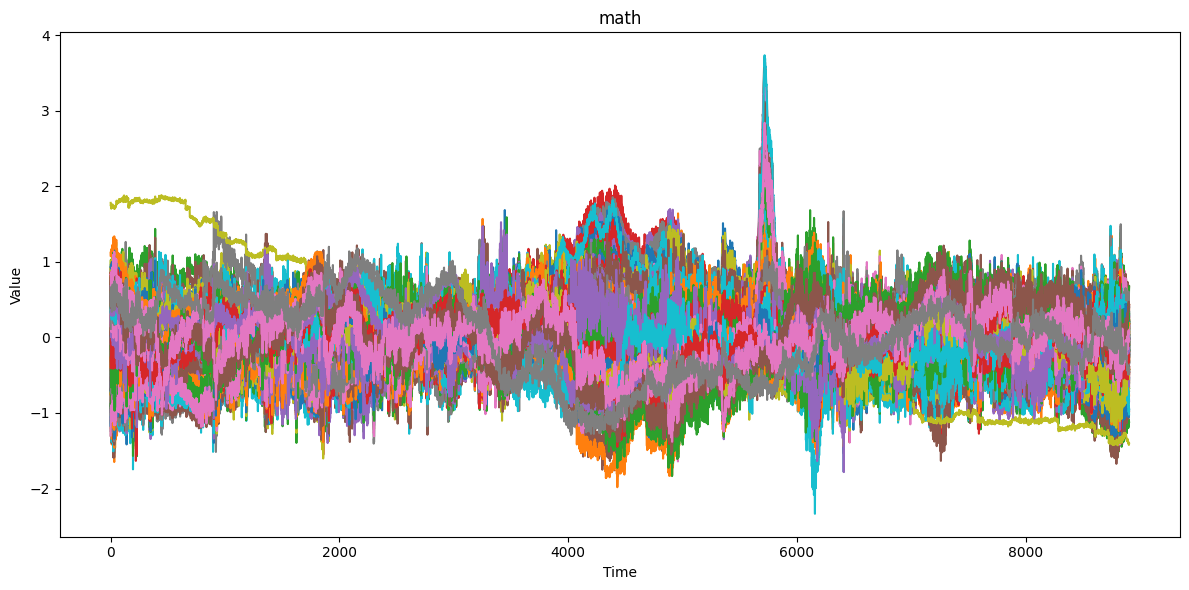

In [10]:
plt.figure(figsize=(12, 6))
for i in range(248):  # You can increase this to show more rows
    plt.plot(story_math_data[i], label=f"Row {i}")

plt.xlabel("Time")
plt.ylabel("Value")
plt.title("math")
plt.tight_layout()
plt.show()

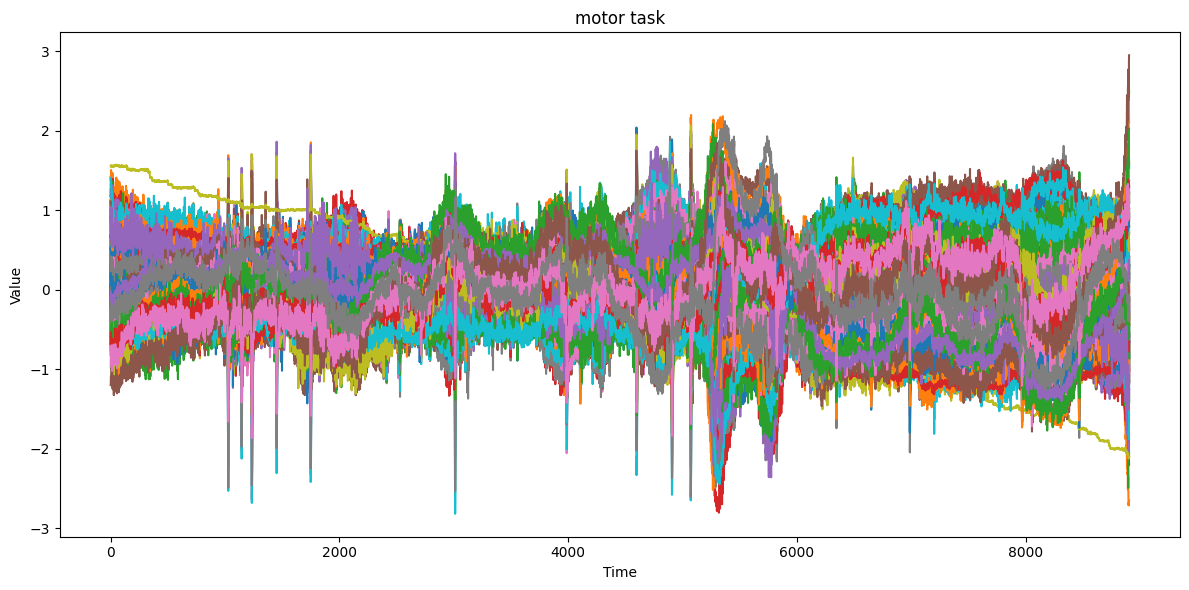

In [11]:
plt.figure(figsize=(12, 6))
for i in range(248):  # You can increase this to show more rows
    plt.plot(motor_data[i], label=f"Row {i}")

plt.xlabel("Time")
plt.ylabel("Value")
plt.title("motor task")
plt.tight_layout()
plt.show()

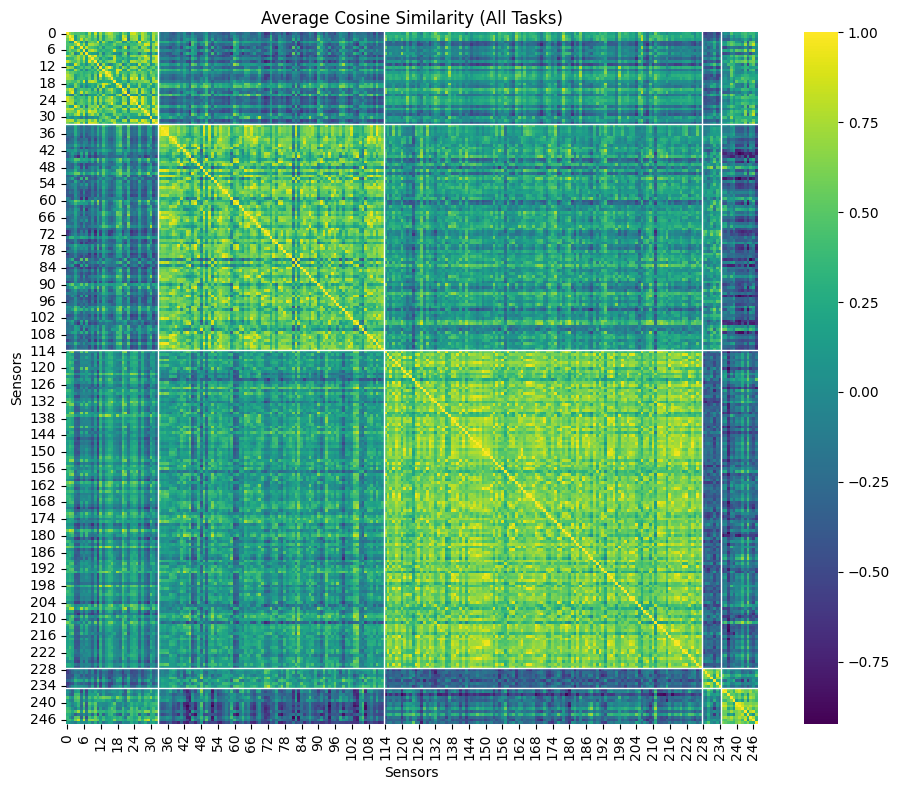

In [12]:
plot_avg_sensor_similarity(
    sim_matrix=avg_sim_matrix,
    sensor_order=sensor_order,
    cluster_labels=cluster_labels,
    title="Average Cosine Similarity (All Tasks)"
)

### Simple FFN

In [13]:
def extract_snapshots(data, time_per_snapshot=32, agg_func=np.mean, method='time'):
    """
    Extract 1s snapshots with time or space aggregation.
    """
    sensors, total_time = data.shape
    snapshots = []
    for start in range(0, total_time - time_per_snapshot + 1, time_per_snapshot):
        snap = data[:, start:start + time_per_snapshot]
        if method == 'time':
            agg = agg_func(snap, axis=1)
        else:
            agg = agg_func(snap, axis=0)
        snapshots.append(agg)
    return np.stack(snapshots)


### Aggregate the time dimension

In [14]:

label_map = {
    "rest": 0,
    "motor": 1,
    "story_math": 2,
    "wm": 3
}

# Prepare snapshot-level dataset
X_rest = extract_snapshots(rest_data, method='time')
X_motor = extract_snapshots(motor_data, method='time')
X_story = extract_snapshots(story_math_data, method='time')
X_wm = extract_snapshots(wm_data, method='time')

y_rest = np.full((X_rest.shape[0],), label_map['rest'])
y_motor = np.full((X_motor.shape[0],), label_map['motor'])
y_story = np.full((X_story.shape[0],), label_map['story_math'])
y_wm = np.full((X_wm.shape[0],), label_map['wm'])

X_all = np.concatenate([X_rest, X_motor, X_story, X_wm])
y_all = np.concatenate([y_rest, y_motor, y_story, y_wm])


# shuffle??
X_train, X_val, y_train, y_val = train_test_split(
    X_all, y_all, test_size=0.2, stratify=y_all, random_state=42)

In [18]:
# Prepare data
# Build FFNN model
#!pip install --upgrade --force-reinstall scikit-learn scikeras
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.optimizers import Adam
def build_ffnn(input_shape, dense_units=128, dropout_rate=0.3, num_classes=4):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Dense(dense_units, activation='relu'),
        layers.Dropout(dropout_rate),
        layers.Dense(dense_units // 2, activation='relu'),
        layers.Dropout(dropout_rate),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

def model_builder(dense_units=128, dropout_rate=0.3, learning_rate=1e-3):
    model = build_ffnn(input_shape=(X_train.shape[1],),
                       dense_units=dense_units,
                       dropout_rate=dropout_rate,
                       num_classes=4)
    model.compile(optimizer=Adam(learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model


In [19]:
param_grid = {
    'dense_units': [64, 128, 256],
    'dropout_rate': [0.2, 0.4],
    'learning_rate': [1e-3, 5e-4],
    'batch_size': [16, 32],
    'epochs': [10, 20]  # Start light; increase later
}


In [20]:
from sklearn.model_selection import GridSearchCV

clf = KerasClassifier(model=model_builder,
                      loss="sparse_categorical_crossentropy", # Specify loss here
                      metrics=["accuracy"], # Specify metrics here
                      verbose=0)

grid = GridSearchCV(estimator=clf,
                    param_grid=param_grid,
                    cv=3,
                    scoring='accuracy',
                    n_jobs=-1)

grid_result = grid.fit(X_train, y_train)


AttributeError: 'super' object has no attribute '__sklearn_tags__'

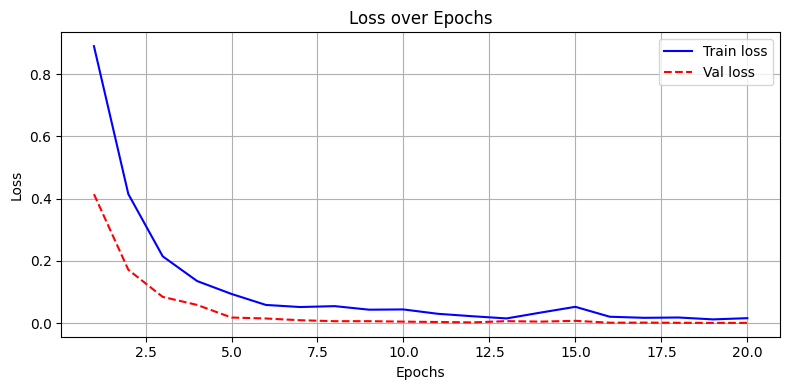

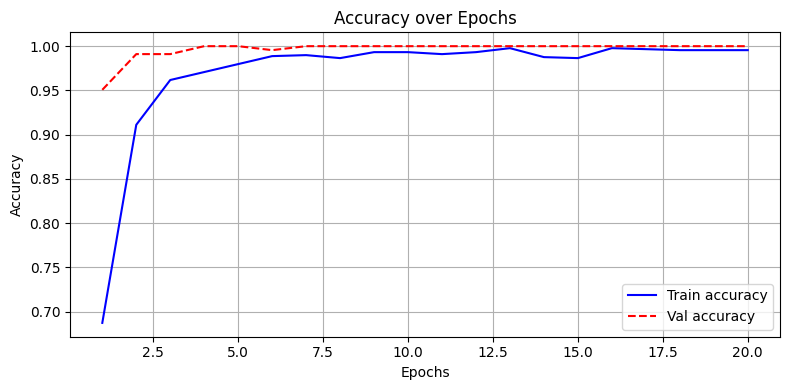

In [34]:
plot_training_history(snapshot_history, metrics=['loss', 'accuracy'])

In [35]:
from scipy.stats import mode

def predict_full_sequence(model, data, method='time', time_per_snapshot=32, agg='mean'):
    snapshots = extract_snapshots(data, time_per_snapshot, method=method)
    snapshots = np.asarray(snapshots)  # Ensure it's a proper ndarray
    probs = model.predict(snapshots)   # Shape: (num_snapshots, num_classes)

    if agg == 'mean':
        return int(np.argmax(np.mean(probs, axis=0)))
    elif agg == 'vote':
        preds = np.argmax(probs, axis=1)
        return int(mode(preds).mode[0])
    else:
        raise ValueError("Unsupported aggregation method.")



In [36]:
X_sequences = [rest_data, motor_data, story_math_data, wm_data]
y_true = [0, 1, 2, 3]  # true labels corresponding to above

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


y_pred = [predict_full_sequence(snapshot_model, seq, method = 'time') for seq in X_sequences]
print("Accuracy:", accuracy_score(y_true, y_pred))
print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=label_map.keys()))
print("\nConfusion Matrix:\n", confusion_matrix(y_true, y_pred))
print("Snapshot validation accuracy:", snapshot_model.evaluate(X_val, y_val)[1])
print("Sequence aggregated accuracy:", accuracy_score(y_true, y_pred))

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Accuracy: 1.0

Classification Report:
               precision    recall  f1-score   support

        rest       1.00      1.00      1.00         1
       motor       1.00      1.00      1.00         1
  story_math       1.00      1.00      1.00         1
          wm       1.00      1.00      1.00         1

    accuracy                           1.00         4
   macro avg       1.00      1.00      1.00         4
weighted avg       1.00      1.00      1.00         4


Confusion Matrix:
 [[1 0 0 0]
 [0 1 0 0]
 [0 0 1 0]
 [0 0 0 1]]
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 1.0000 - loss: 7.5628e-04
Snapshot validation accuracy: 1.0
Sequence aggregated accuracy: 1.0


### Aggregate the space dimension

In [37]:

label_map = {
    "rest": 0,
    "motor": 1,
    "story_math": 2,
    "wm": 3
}

# Prepare snapshot-level dataset
X_rest = extract_snapshots(rest_data, method='space')
X_motor = extract_snapshots(motor_data, method='space')
X_story = extract_snapshots(story_math_data, method='space')
X_wm = extract_snapshots(wm_data, method='space')

y_rest = np.full((X_rest.shape[0],), label_map['rest'])
y_motor = np.full((X_motor.shape[0],), label_map['motor'])
y_story = np.full((X_story.shape[0],), label_map['story_math'])
y_wm = np.full((X_wm.shape[0],), label_map['wm'])

X_all = np.concatenate([X_rest, X_motor, X_story, X_wm])
y_all = np.concatenate([y_rest, y_motor, y_story, y_wm])


# shuffle??
X_train, X_val, y_train, y_val = train_test_split(
    X_all, y_all, test_size=0.2, stratify=y_all, random_state=42)

In [38]:
snapshot_model_space = build_ffnn(input_shape=(X_train.shape[1],))

snapshot_model_space.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Train
snapshot_space_history = snapshot_model_space.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=16,
    verbose=1
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.2295 - loss: 1.3859 - val_accuracy: 0.3004 - val_loss: 1.3749
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.3078 - loss: 1.3620 - val_accuracy: 0.3677 - val_loss: 1.3636
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.3547 - loss: 1.3638 - val_accuracy: 0.3274 - val_loss: 1.3511
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3326 - loss: 1.3489 - val_accuracy: 0.3498 - val_loss: 1.3487
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.3403 - loss: 1.3459 - val_accuracy: 0.3722 - val_loss: 1.3315
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4057 - loss: 1.3244 - val_accuracy: 0.4215 - val_loss: 1.3138
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.3596 - loss: 1.3345 - val_accuracy: 0.3946 - val_loss: 1.3110
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4007 - loss: 1.3081 - val_accuracy: 0.4260 - val_lo

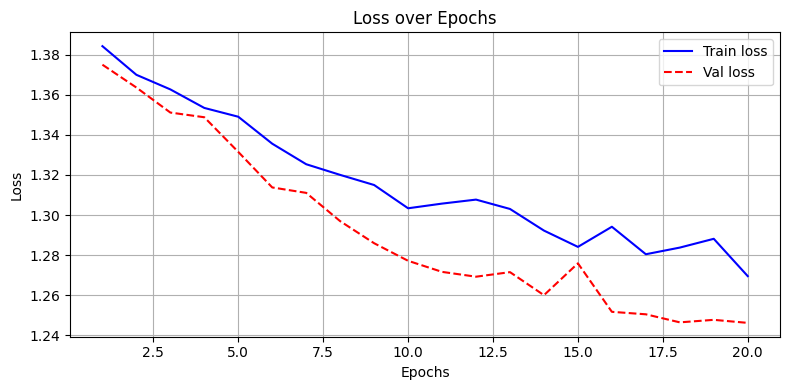

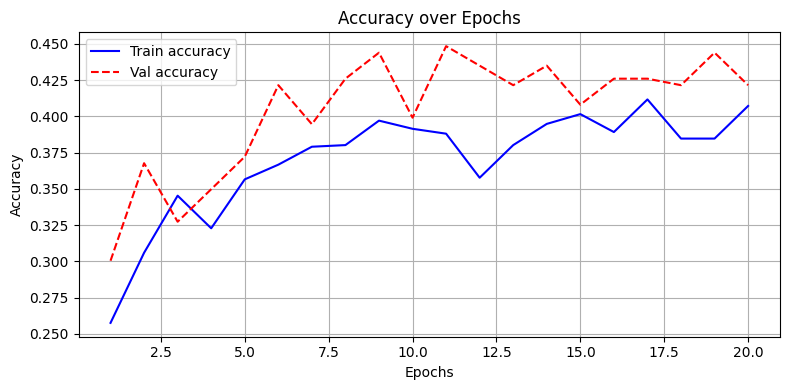

In [39]:
plot_training_history(snapshot_space_history, metrics=['loss', 'accuracy'])

In [40]:
from scipy.stats import mode

def predict_full_sequence(model, data, method = 'space', time_per_snapshot=32, agg='mean'):
    snapshots = extract_snapshots(data, method = method, time_per_snapshot = time_per_snapshot)
    probs = model.predict(snapshots)

    if agg == 'mean':
        return int(np.argmax(np.mean(probs, axis=0)))
    elif agg == 'vote':
        preds = np.argmax(probs, axis=1)
        return int(mode(preds).mode[0])


In [41]:
X_sequences = [rest_data, motor_data, story_math_data, wm_data]
y_true = [0, 1, 2, 3]  # true labels corresponding to above

y_pred = [predict_full_sequence(snapshot_model_space, seq, method = 'space') for seq in X_sequences]
print("Accuracy:", accuracy_score(y_true, y_pred))
print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=label_map.keys()))
print("\nConfusion Matrix:\n", confusion_matrix(y_true, y_pred))
print("Snapshot validation accuracy:", snapshot_model_space.evaluate(X_val, y_val)[1])
print("Sequence aggregated accuracy:", accuracy_score(y_true, y_pred))


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Accuracy: 1.0

Classification Report:
               precision    recall  f1-score   support

        rest       1.00      1.00      1.00         1
       motor       1.00      1.00      1.00         1
  story_math       1.00      1.00      1.00         1
          wm       1.00      1.00      1.00         1

    accuracy                           1.00         4
   macro avg       1.00      1.00      1.00         4
weighted avg       1.00      1.00      1.00         4


Confusion Matrix:
 [[1 0 0 0]
 [0 1 0 0]
 [0 0 1 0]
 [0 0 0 1]]
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.4150 - loss: 1.2486
Snapshot validation accuracy: 0.42152467370033264
Sequence aggregated accuracy: 1.0
